In [339]:
import etl_eda
import importlib
importlib.reload(etl_eda)
from etl_eda import *
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, normaltest, spearmanr
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [345]:
train = load('train.csv')
categories = load('item_categories.csv')
shops = load('shops.csv')
items  = load('items.csv')

In [5]:
train[['item_cnt_day', 'item_price']].describe().map(lambda x: f"{x:0.1f}")

,item_cnt_day,item_price
count,2935843.0,2935843.0
mean,1.2,890.7
std,2.2,1719.9
min,0.0,0.1
25%,1.0,249.0
50%,1.0,399.0
75%,1.0,999.0
max,669.0,49782.0


ITEM_CNT_DAY

Item_cnt_day destribution

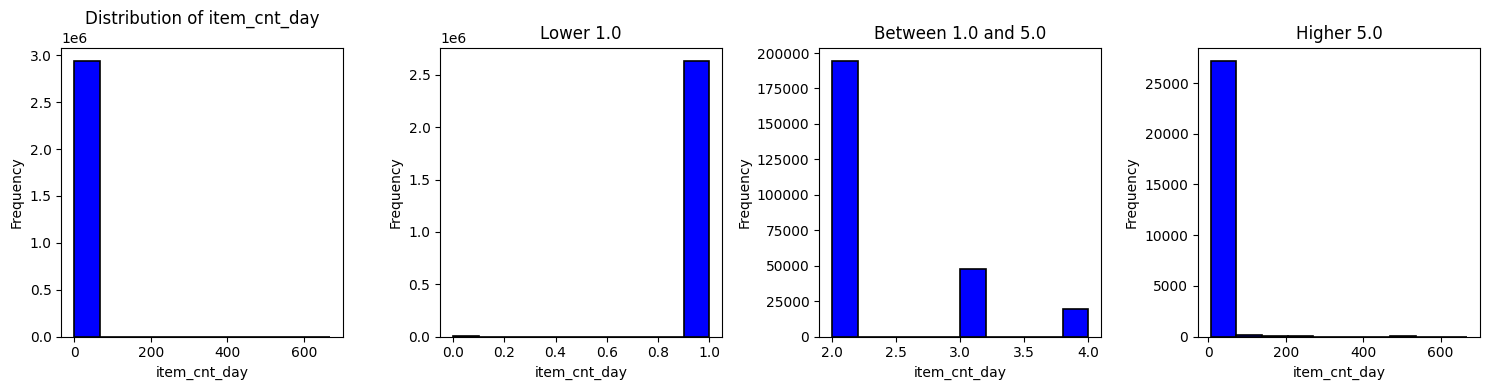

In [13]:
distribution(train, 'item_cnt_day')

Distribution of 'item_cnt_day' is right skewed, the biggest frequency we see with item_cnt_day = (1e6). Also we get 3 plots of different range(percentiles) of item_cnt_day values. 1st plot - 1%, 2nd - 1-99%, 3d - 99%. Most of the values are under 3.

In [14]:
print(f'Min of item_cnt_month is {min(train.item_cnt_day)}')
print(f'Max of item_cnt_month is {max(train.item_cnt_day)}')

Min of item_cnt_month is 0.0
Max of item_cnt_month is 669.0


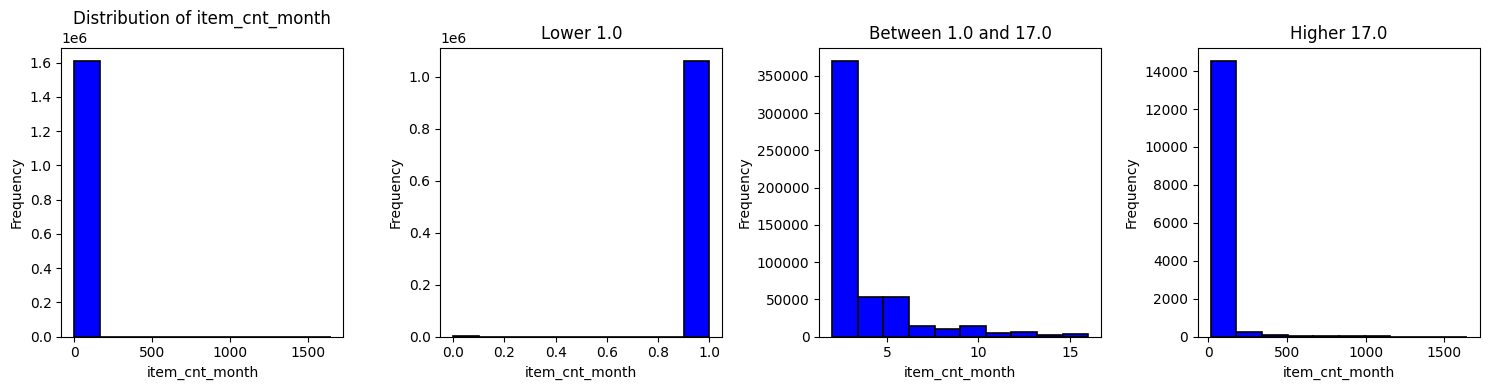

In [17]:
group = train.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().rename('item_cnt_month').reset_index()
distribution(group, 'item_cnt_month')

As for the target distribution of 'item_cnt_month' is also right skewed, the biggest frequency we see with item_cnt_month = (1e6) - it means that most of the items are sold once a month. Most of the values are under 17.

ITEM_PRICE

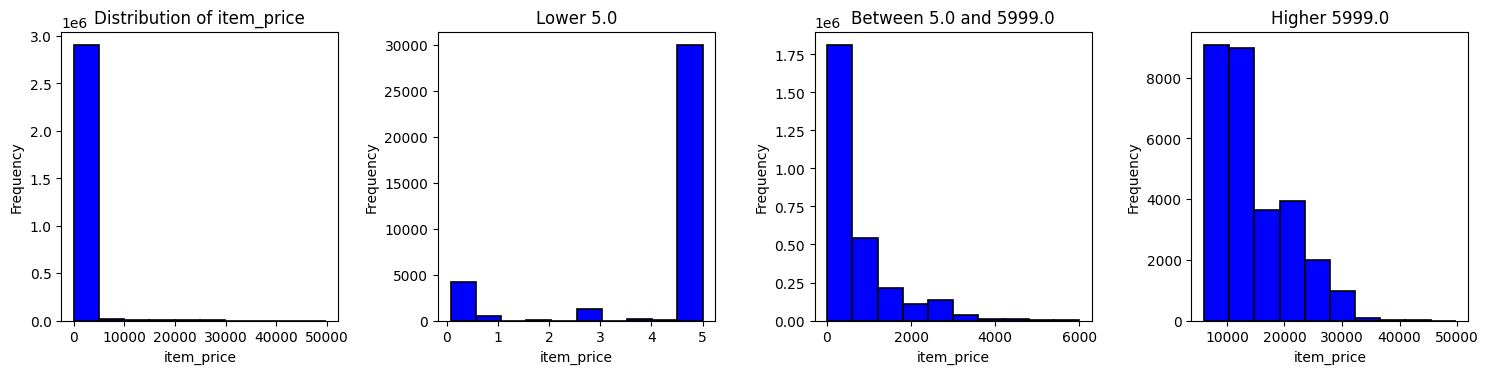

In [18]:
distribution(train, 'item_price')

Distribution of item price is right skewed. The biggest part of item prices are laying between 5 and 1000

In [19]:
print(f'Min of item_price is {min(train.item_price)}')
print(f'Max of item_price is {max(train.item_price)}')

Min of item_price is 0.07
Max of item_price is 49782.0


Item_cnt_month behavior during the analyzed period

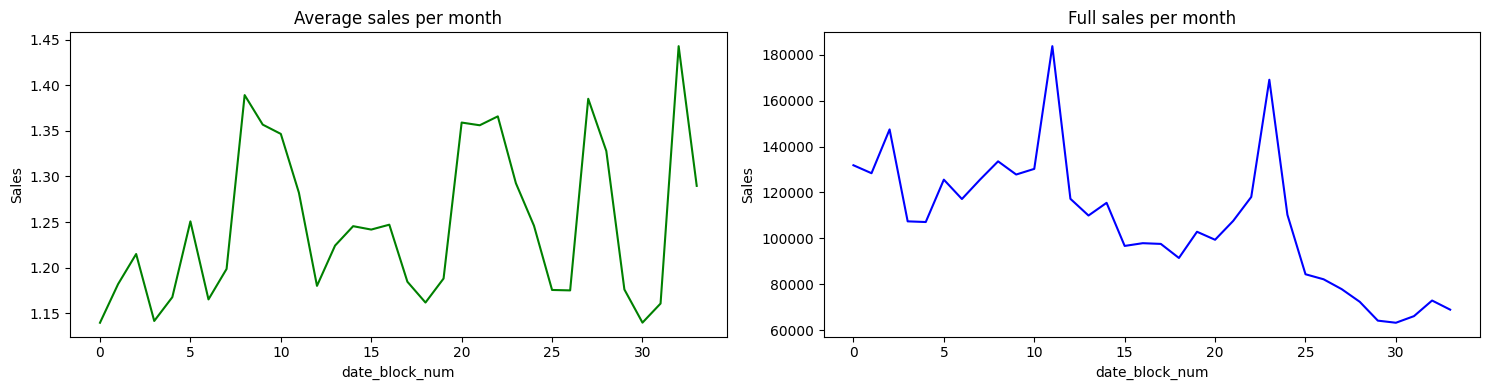

In [23]:
figure, ax = plt.subplots(1,2, figsize = (15,4))

sns.lineplot(data = train.groupby('date_block_num').agg({'item_cnt_day': 'mean'}), x = 'date_block_num', y = 'item_cnt_day', c = 'g', ax = ax[0]).set_title('Average sales per month')

sns.lineplot(data = train.groupby('date_block_num').agg({'item_cnt_day': 'sum'}), x = 'date_block_num', y = 'item_cnt_day', c = 'b', ax = ax[1]).set_title('Full sales per month')

ax[0].set_ylabel('Sales')
ax[1].set_ylabel('Sales')

plt.tight_layout()
plt.show()

Sales have the term of seasonality. Also, when analyzing full sales , we can see a tendency to decrease sales by the end of the analyzed period

Time-influenced features engineering

In [341]:
group = train.groupby('date_block_num').agg({'item_cnt_day': ['sum', 'mean']})
group = group.reset_index()
group.columns = group.columns.set_levels(['item_cnt_month', 'date_block_num'],level=0)
group['date'] = pd.date_range(start='2013-01-01', periods=34, freq='ME')
group['month'] = group['date'].dt.month
group['year'] = group['date'].dt.year
del group['date']

Item_cnt_month behavior during the year

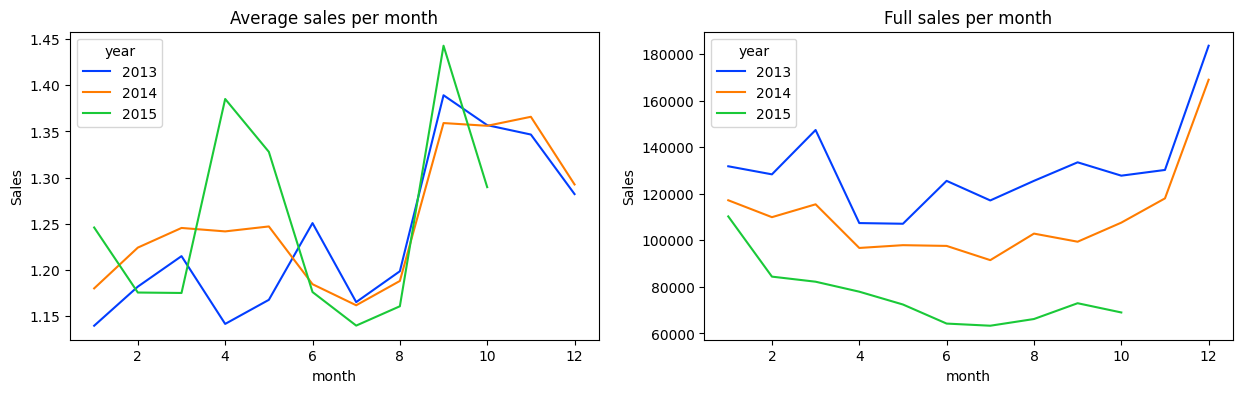

In [54]:
figure, ax = plt.subplots(1,2, figsize = (15,4))

sns.lineplot(data = group, x = 'month', y = ('item_cnt_month', 'mean'), hue = 'year', palette='bright', ax = ax[0]).set_title('Average sales per month')

sns.lineplot(data = group, x = 'month', y = ('item_cnt_month', 'sum'), hue = 'year', palette='bright', ax = ax[1]).set_title('Full sales per month')

ax[0].set_ylabel('Sales')
ax[1].set_ylabel('Sales')

plt.show()

Average sales: each period has it's own period of seasonality. Sales from the 2013 and 2014 years behave similarly. Dinamics of sales in 2015 started to differ (in the beggining and in the middle of the year). We do not have data to see how sales will behave at the end of 2015, but according to the general pattern - we will probably see an increase

Full sales: According to our data, sales have been declining with each subsequent year

In [342]:
group = group.droplevel(1, axis=1)[['date_block_num', 'month', 'year']]
train = pd.merge(train, group, on = 'date_block_num', how = 'left')

In [59]:
group = train.groupby(['date_block_num', 'shop_id'])['item_cnt_day'].sum().rename('item_cnt_month_per_shop').reset_index()
group = pd.merge(group, shops, on = 'shop_id', how = 'left')
sales_per_shop = group.sort_values(by = 'item_cnt_month_per_shop', ascending = False)

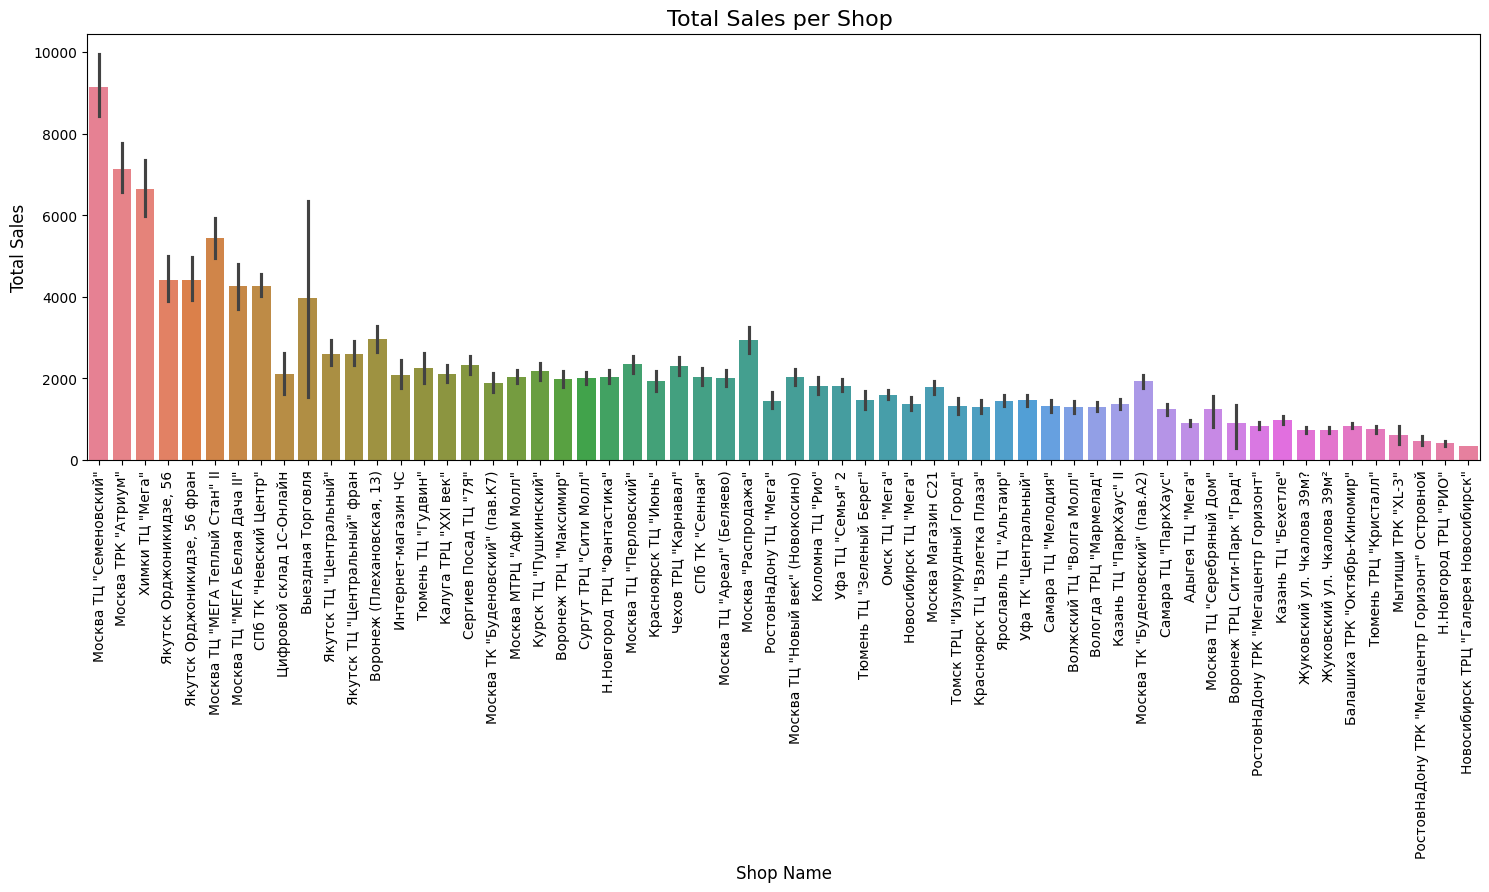

In [65]:
plt.figure(figsize = (15,10))

sns.barplot(data = sales_per_shop, x = 'shop_name', y = 'item_cnt_month_per_shop', hue = 'shop_name')

plt.xticks(rotation=90)

plt.title('Total Sales per Shop ', fontsize=16 )
plt.xlabel('Shop Name', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.tight_layout()
plt.legend().set_visible(False)
plt.show()

Sales depend on the type of shop and it's location. Most of the sales take place in big cities.

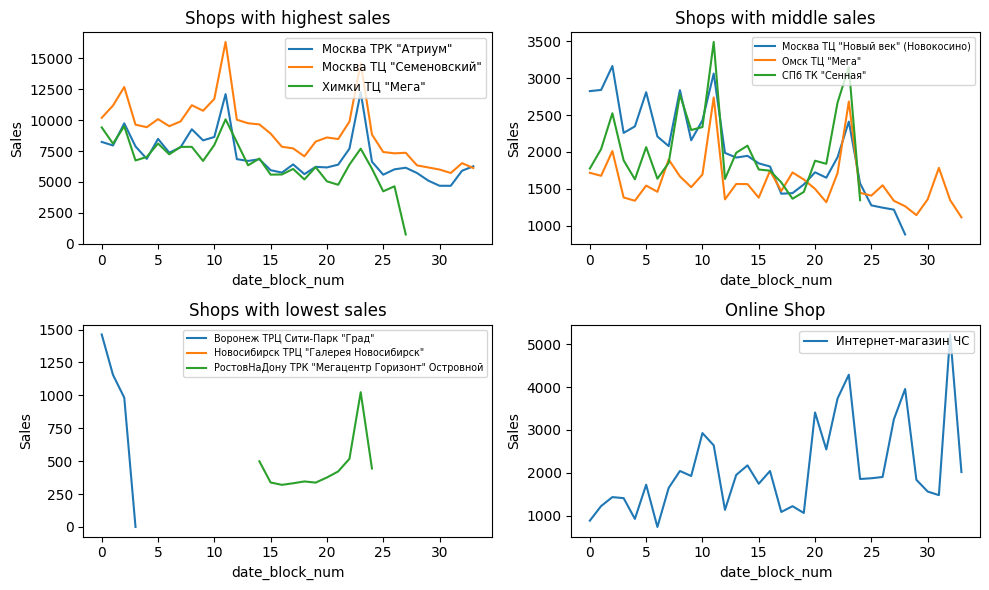

In [122]:
#Sales per shop
shop_sales = sales_per_shop.groupby(['shop_id', 'shop_name'])['item_cnt_month_per_shop'].sum().reset_index()
#Sorting by sales
shop_sales_sorted = shop_sales.sort_values(by='item_cnt_month_per_shop', ascending=False)

#Shops with highest, middle, lowest sales. + Online shop
highest_names = shop_sales_sorted.iloc[:3].shop_name
highest = pd.pivot_table(sales_per_shop[sales_per_shop.shop_name.isin(highest_names)], values='item_cnt_month_per_shop', columns=['date_block_num'], index=['shop_name'], aggfunc="sum").T
middle_names = shop_sales_sorted.iloc[(len(shop_sales_sorted)//2-1):(len(shop_sales_sorted)//2+2)].shop_name
middle = pd.pivot_table(sales_per_shop[sales_per_shop.shop_name.isin(middle_names)], values='item_cnt_month_per_shop', columns=['date_block_num'], index=['shop_name'], aggfunc="sum").T
lowest_names = shop_sales_sorted.iloc[-3:].shop_name
lowest = pd.pivot_table(sales_per_shop[sales_per_shop.shop_name.isin(lowest_names)], values='item_cnt_month_per_shop', columns=['date_block_num'], index=['shop_name'], aggfunc="sum").T
online_name = 'Интернет-магазин ЧС'
online = pd.pivot_table(sales_per_shop[sales_per_shop.shop_name==online_name], values='item_cnt_month_per_shop', columns=['date_block_num'], index=['shop_name'], aggfunc="sum").T

fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (10, 6))

p1 = highest.plot(ax=axes[0,0], ylabel = 'Sales', title = 'Shops with highest sales')
p1.legend(loc = 'upper right', fontsize = 'small')
p2 = middle.plot(ax=axes[0,1], ylabel = 'Sales', title = 'Shops with middle sales')
p2.legend(loc = 'upper right', fontsize = 'x-small')
p3 = lowest.plot(ax=axes[1,0], ylabel = 'Sales', title = 'Shops with lowest sales')
p3.legend(loc = 'upper right', fontsize = 'x-small')
p4 = online.plot(ax=axes[1,1], ylabel = 'Sales', title = 'Online Shop')
p4.legend(loc = 'upper right', fontsize = 'small')

plt.tight_layout()
plt.show()

1) Highest and middle sales
We see similar sales trends for different shops in the upper and middle sections. For some shops data is missing, but we see general trends and can make predictions if we fill in the missing values
2) Lowest sales
The graphs of the shops with the lowest sales show large data missing - making predictions on these shops can lead to errors. It would be logical to take a closer look at the shops that do not have data for the full analyzed period.
3) Online shop
Based on the overall graph, the online shop is 15th in terms of sales. However, it can be seen that closer to the end of the analyzed period, unlike offline shops, there is a tendency to increase sales.

C:\Users\User\AppData\Local\Temp\ipykernel_36548\1270065838.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize = 'x-small')


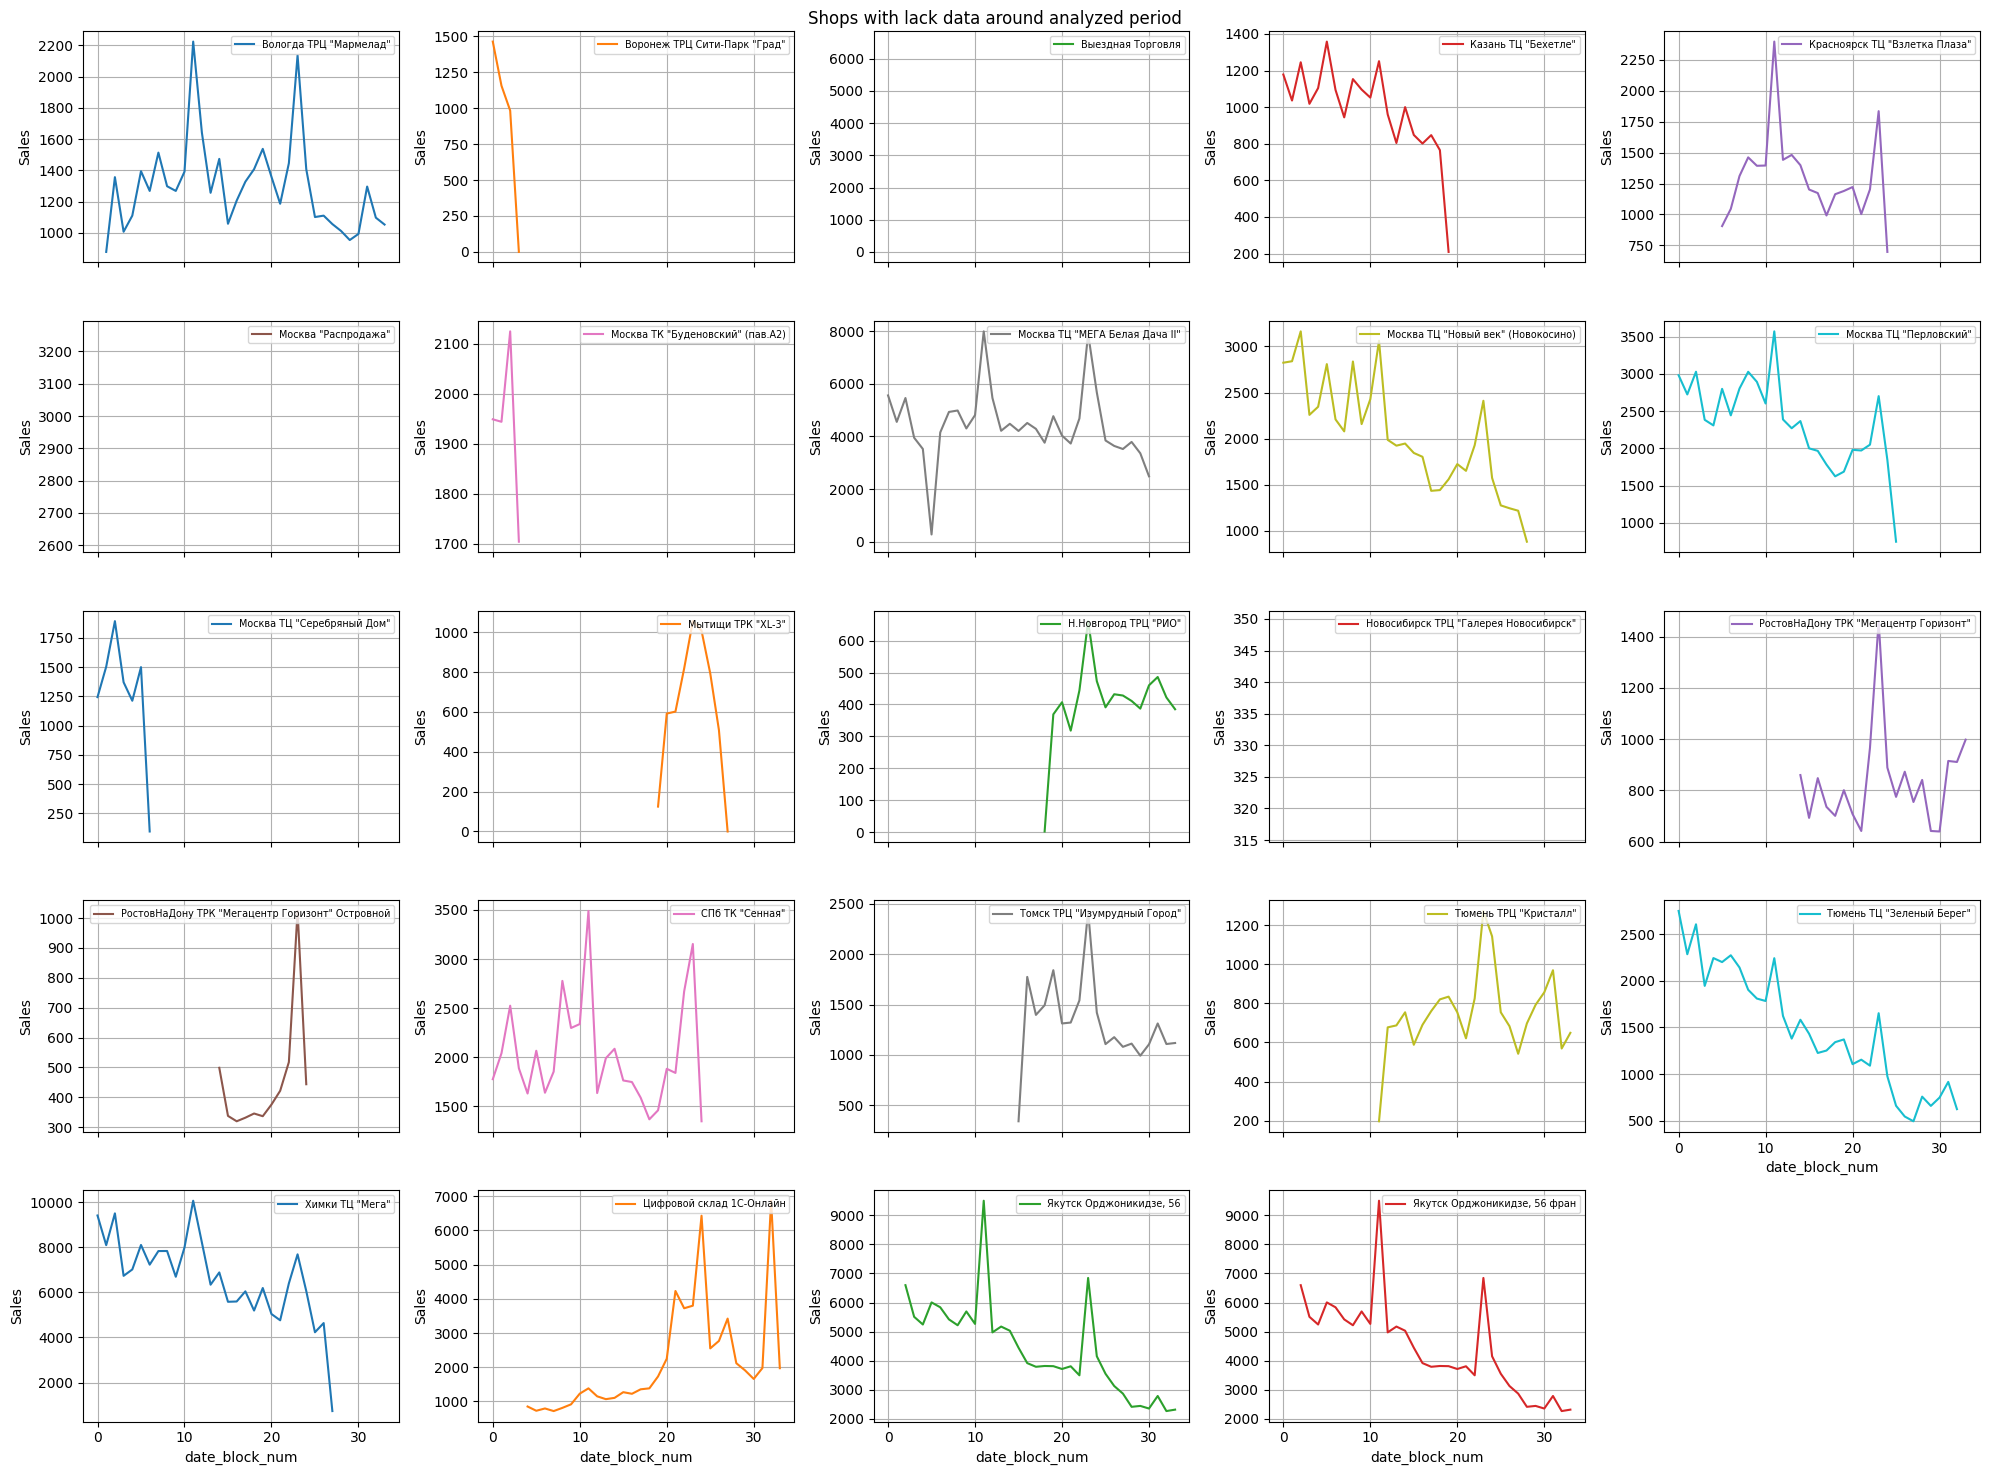

In [128]:
#Plotting not full data shops
shops_group = pd.pivot_table(sales_per_shop, values='item_cnt_month_per_shop', columns=['date_block_num'], index=['shop_name'], aggfunc="sum")
axes = shops_group[shops_group.isna().any(axis = 1)].T.plot(subplots = True, layout = (5,5), grid=True,sharex=True, sharey=False,figsize=(20,15), title = 'Shops with lack data around analyzed period')

axes = axes.flat 

for ax in axes:
    
    ax.legend(loc='upper right', fontsize = 'x-small')
    ax.set_ylabel('Sales')

plt.tight_layout()
plt.show()


For some shops we don't have trends even for one full year, they will add a lot of bias to our final model. But deleting them can be dangerous, because they could contain useful information for future predictions. In the future, it will be useful to add a feature that reflects the number of available time blocks for a store (shop history length), thereby factoring this into the prediction.

In [130]:
#Exctraction of city name from shop name
encoder = LabelEncoder()
shops['city'] = shops['shop_name'].str.split(' ').apply(lambda x: x[0])
shops.replace({'city': 'Сергиев'}, 'Сергиев Посад', inplace=True)
shops['city_id'] = encoder.fit_transform(shops['city'])

In [169]:
group = pd.merge(sales_per_shop, shops, on = ['shop_id', 'shop_name'], how = 'right')
sales_per_city = (group.groupby(['date_block_num', 'city', 'city_id'])['item_cnt_month_per_shop']
                .sum().rename('item_cnt_month_per_city').reset_index()
                .sort_values(by = 'item_cnt_month_per_city', ascending = False))

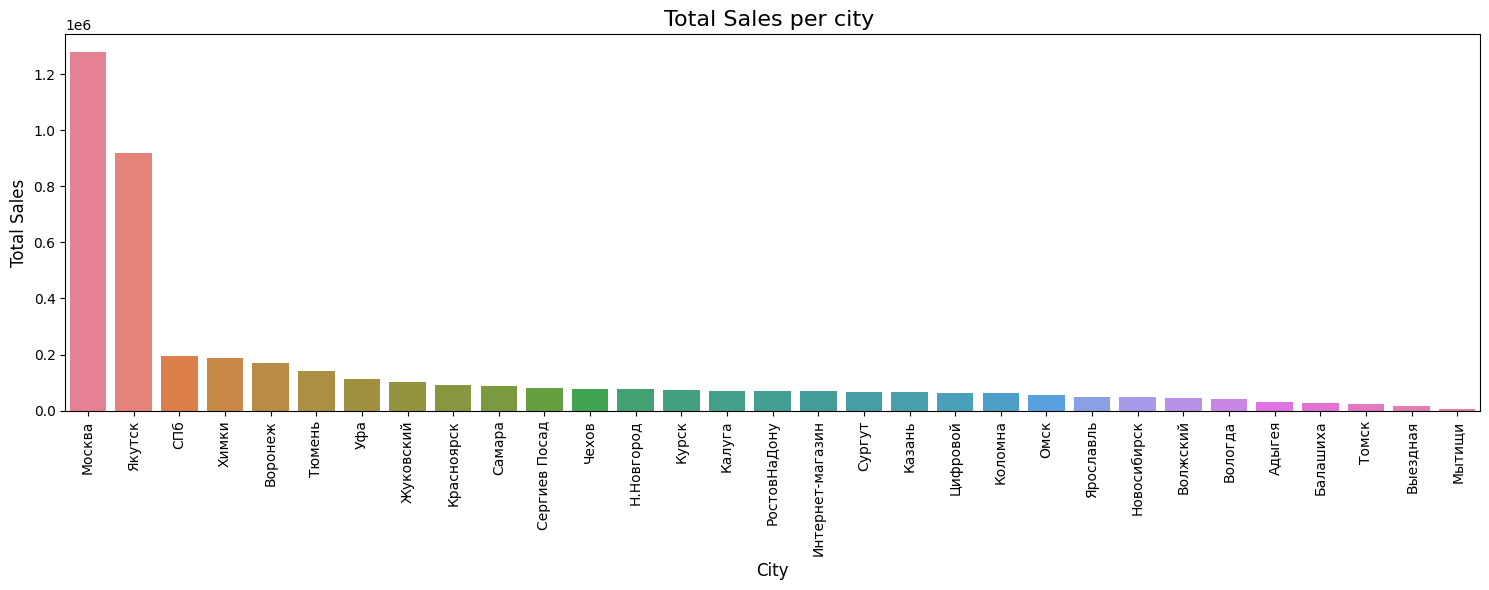

In [ ]:
plt.figure(figsize = (15,6))

sns.barplot(data = sales_per_city, x = 'city', y = 'item_cnt_month_per_city', hue = 'city')

plt.xticks(rotation=90)

plt.title('Total Sales per city ', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)

plt.tight_layout()
plt.show()

Sales are higher in big cities. The highest sales are observed in the capital of the country - Moscow.

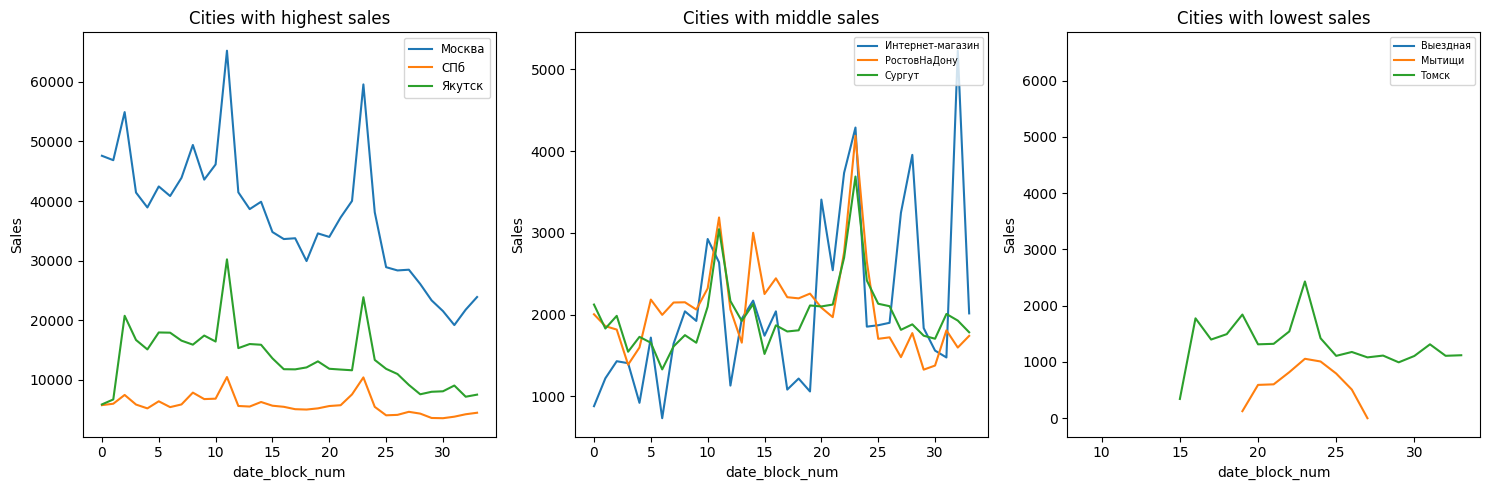

In [174]:
#Sales per city
city_sales = sales_per_city.groupby(['city_id', 'city'])['item_cnt_month_per_city'].sum().reset_index()
#Sorting by sales
city_sales_sorted = city_sales.sort_values(by='item_cnt_month_per_city', ascending=False)

#Shops with highest, middle, lowest sales. + Online shop
highest_names = city_sales_sorted.iloc[:3].city
highest = pd.pivot_table(sales_per_city[sales_per_city.city.isin(highest_names)], values='item_cnt_month_per_city', columns=['date_block_num'], index=['city'], aggfunc="sum").T
middle_names = city_sales_sorted.iloc[(len(city_sales_sorted)//2-1):(len(city_sales_sorted)//2+2)].city
middle = pd.pivot_table(sales_per_city[sales_per_city.city.isin(middle_names)], values='item_cnt_month_per_city', columns=['date_block_num'], index=['city'], aggfunc="sum").T
lowest_names = city_sales_sorted.iloc[-3:].city
lowest = pd.pivot_table(sales_per_city[sales_per_city.city.isin(lowest_names)], values='item_cnt_month_per_city', columns=['date_block_num'], index=['city'], aggfunc="sum").T

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))

p1 = highest.plot(ax=axes[0], ylabel = 'Sales', title = 'Cities with highest sales')
p1.legend(loc = 'upper right', fontsize = 'small')
p2 = middle.plot(ax=axes[1], ylabel = 'Sales', title = 'Cities with middle sales')
p2.legend(loc = 'upper right', fontsize = 'x-small')
p3 = lowest.plot(ax=axes[2], ylabel = 'Sales', title = 'Cities with lowest sales')
p3.legend(loc = 'upper right', fontsize = 'x-small')

plt.tight_layout()
plt.show()

As in shop trends, sales with lowest sales in cities do not have full range of data. It will be reasonable to create features that will use this information. Moscow stands out in terms of sales, as it contains the largest number of population and shops. Cities with highest and middle sales have similar seasonality term. But we have different tendency for online sales.

Item-price dependence

In [180]:
group = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': 'sum', 'item_price': 'mean'})

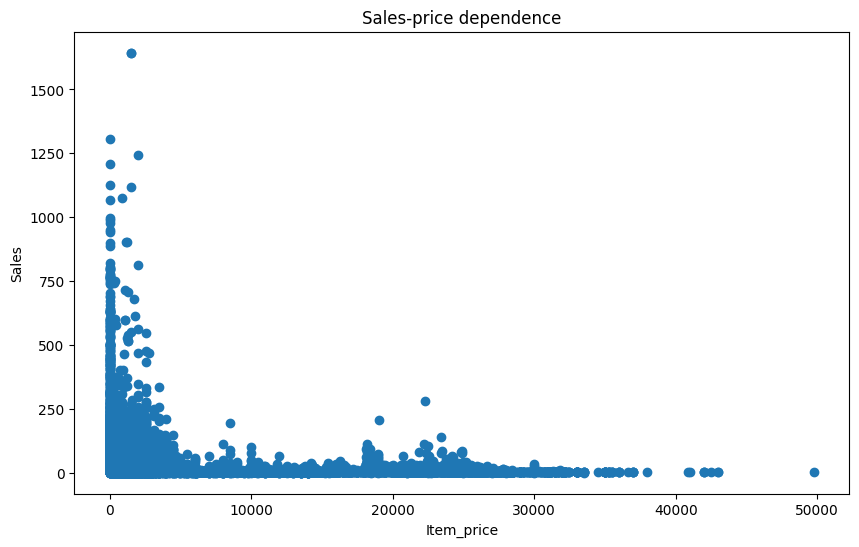

In [181]:
plt.figure(figsize=(10,6))
plt.scatter(x = group['item_price'],
            y = group['item_cnt_day'])

plt.xlabel('Item_price')
plt.ylabel('Sales')
plt.title('Sales-price dependence')

plt.show()

There is no linear correlation between sales per shop per item and item price. To illustrate sales in month dymanics on item price base, it will be reasonable to create new feature - revenue (item_price * item_cnt_month)

Item-category_id dependence

Split of category names into 2 parts: main and minor category

In [182]:
categories['main_category'] = categories['item_category_name'].str.split(' - ').apply(lambda x: x[0])
categories.replace({'main_category': ['Игры PC', 'Игры Android', 'Игры MAC']}, 'Игры', inplace=True)
categories.replace({'main_category': ['Карты оплаты (Кино, Музыка, Игры)']}, 'Карты оплаты', inplace=True)
categories.replace({'main_category': ["PC", 'Чистые носители (штучные)', "Чистые носители (шпиль)", 'Чистые носители']}, 'Аксессуары', inplace=True)
categories.replace({'main_category': ["Билеты (Цифра)", 'Служебные']}, 'Билеты', inplace=True)
categories['main_category_id'] = encoder.fit_transform(categories['main_category'])
categories['minor_category'] = categories['item_category_name'].str.split(' - ').apply(lambda x: x[1] if len(x) > 1 else x[0])
categories['minor_category_id'] = encoder.fit_transform(categories['minor_category'])

In [ ]:
#Groupping by category
categories_items = categories.merge(items, on = 'item_category_id', how = 'left')
group = categories_items.merge(train, on = 'item_id', how = 'left')
#Item_category_id
sales_per_category = (group.groupby(['date_block_num', 'item_category_id'])['item_cnt_day']
                     .sum().rename('item_cnt_per_category').reset_index()
                     .sort_values(by = 'item_cnt_per_category',ascending = False))
#Main category
sales_per_main_category = (group.groupby(['date_block_num', 'main_category'])['item_cnt_day']
                          .sum().rename('item_cnt_per_main_category').reset_index()
                          .sort_values(by = 'item_cnt_per_main_category',ascending = False))
#Minor category
sales_per_minor_category = (group.groupby(['date_block_num', 'minor_category'])['item_cnt_day']
                           .sum().rename('item_cnt_per_minor_category').reset_index()
                           .sort_values(by = 'item_cnt_per_minor_category',ascending = False))

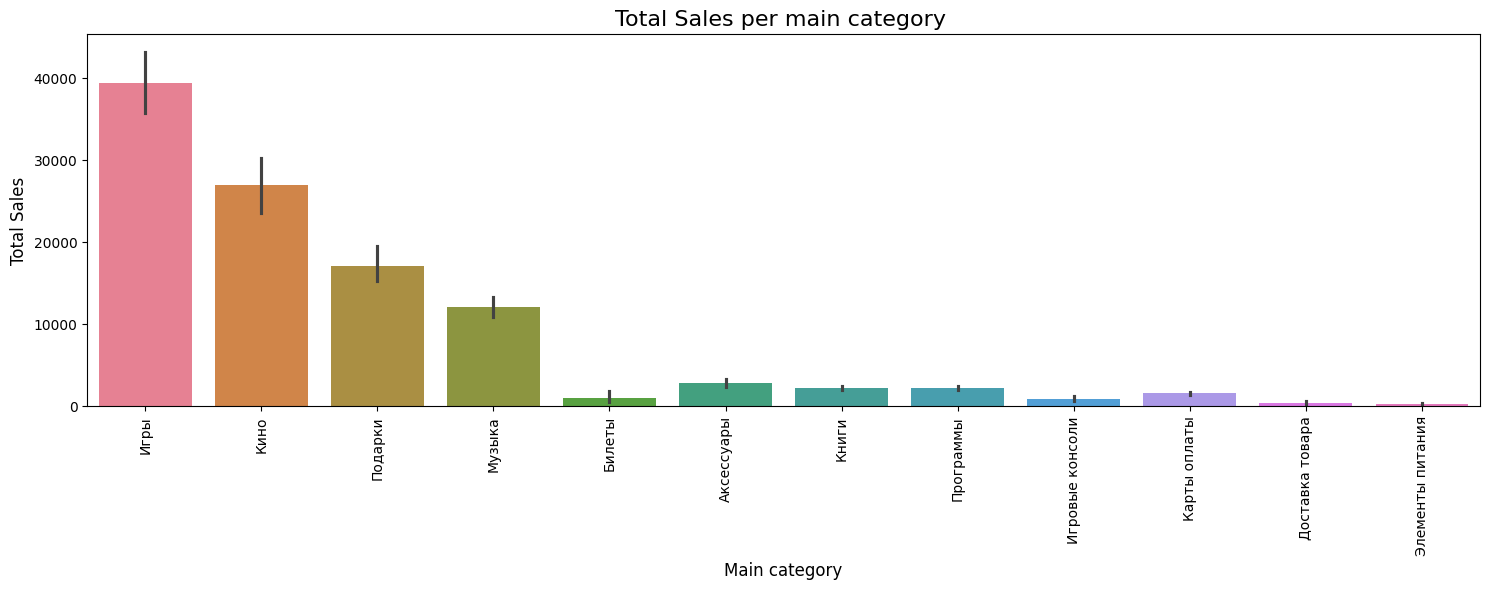

In [214]:
plt.figure(figsize = (15,6))

sns.barplot(data = sales_per_main_category, x = 'main_category', y = 'item_cnt_per_main_category', hue = 'main_category')

plt.xticks(rotation=90)

plt.title('Total Sales per main category ', fontsize=16)
plt.xlabel('Main category', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)

plt.tight_layout()
plt.show()

The highest number of sales is in categories such as Games, Movies and Gifts. The lowest sales in the categories of batteries, which may be due to product specificity.

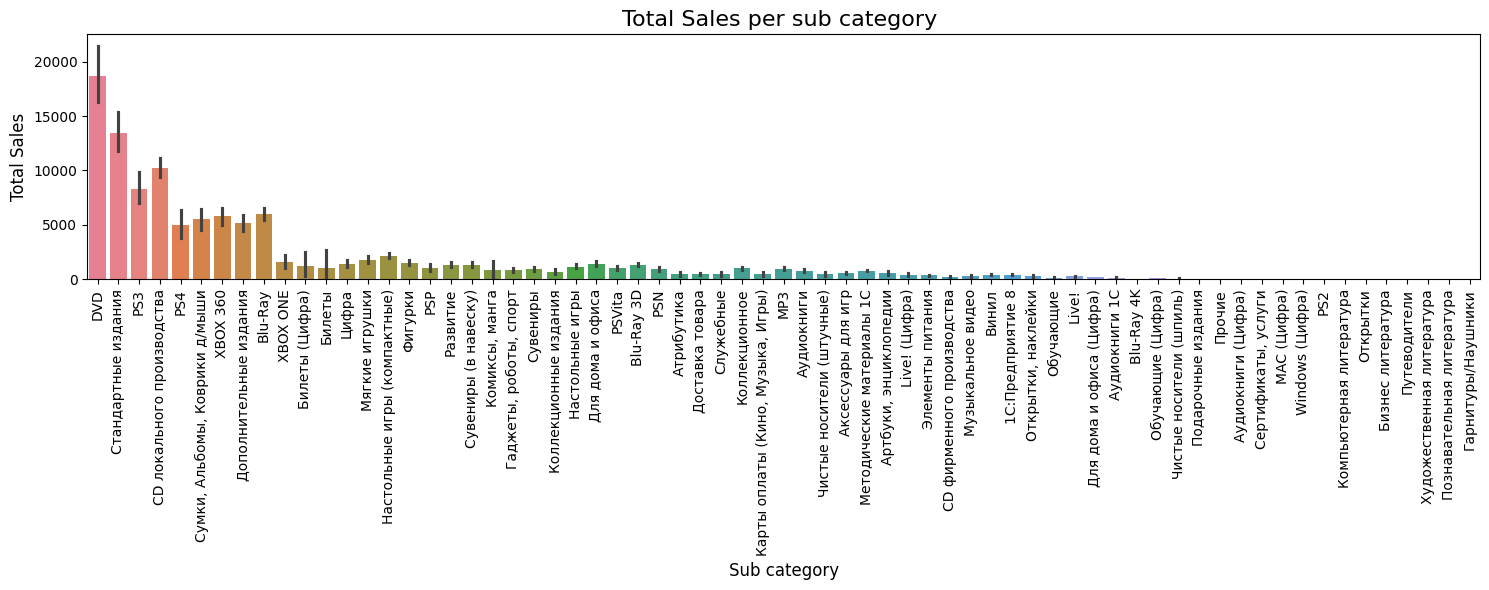

In [215]:
plt.figure(figsize = (15,6))

sns.barplot(data = sales_per_minor_category, x = 'minor_category', y = 'item_cnt_per_minor_category', hue = 'minor_category')

plt.xticks(rotation=90)

plt.title('Total Sales per sub category ', fontsize=16)
plt.xlabel('Sub category', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)

plt.tight_layout()

Plot of 15th most and minor popular subcategories slice -to get more interpritable picture

In [ ]:
minor_category_sales = sales_per_minor_category.groupby(['minor_category'])['item_cnt_per_minor_category'].sum().reset_index()
minor_category_sorted = minor_category_sales.sort_values(by='item_cnt_per_minor_category', ascending=False)

top_categories = minor_category_sorted.iloc[:15].minor_category
bottom_categories = minor_category_sorted.iloc[-15:].minor_category

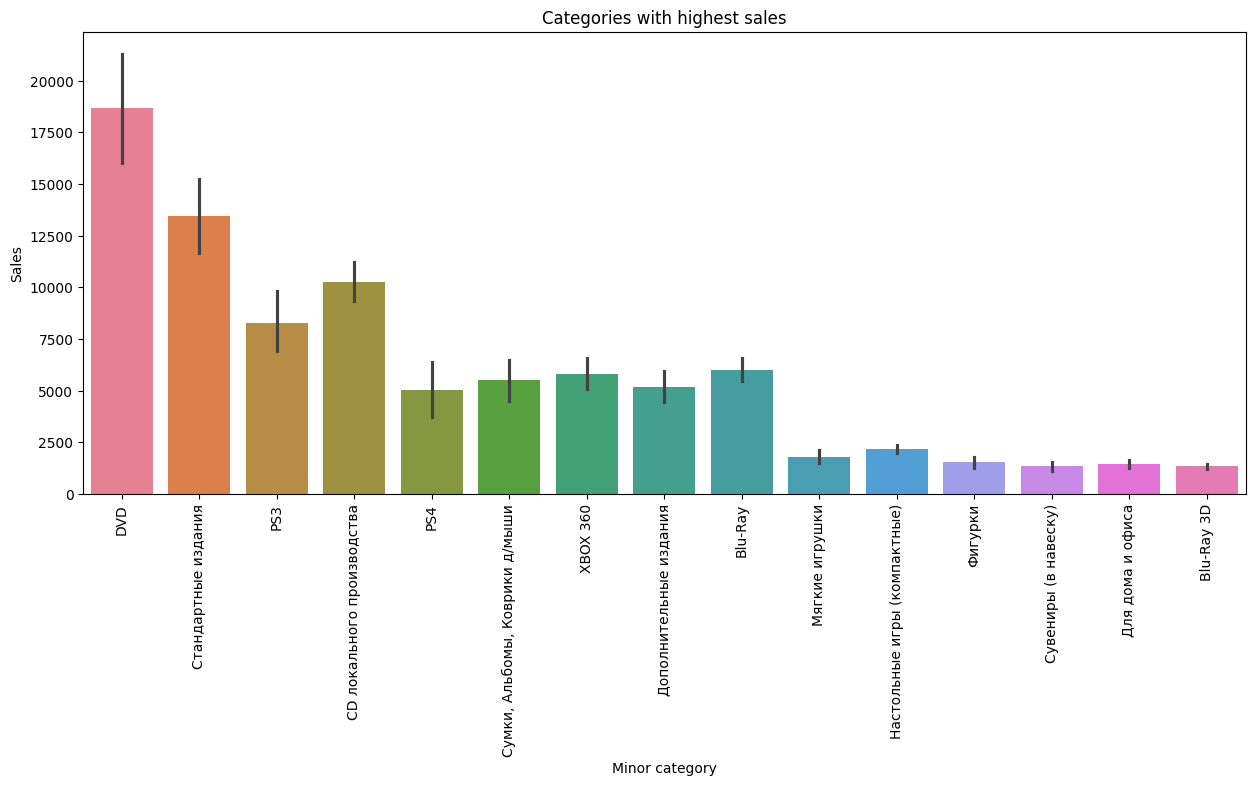

In [247]:
plt.figure(figsize = (15,6))

sns.barplot(data = sales_per_minor_category[sales_per_minor_category.minor_category.isin(top_categories)],
             x = 'minor_category', y = 'item_cnt_per_minor_category', hue = 'minor_category')

plt.title('Categories with highest sales')
plt.xlabel('Minor category')
plt.ylabel('Sales')

plt.xticks(rotation=90)
plt.show()

The largest sales for main category 'Movies' in DVD format, while in Blu-Ray have smaller sales. There are no sales from the 'Cinema' category in less preffered segment. Games sold for PC-стандартные издания, take second place among customers (PC-дополнительные издания are also in the top 15 best-selling subcategories with games for PS3, PS4 and XBOX-360).
Music sold on CDs is on the third place.

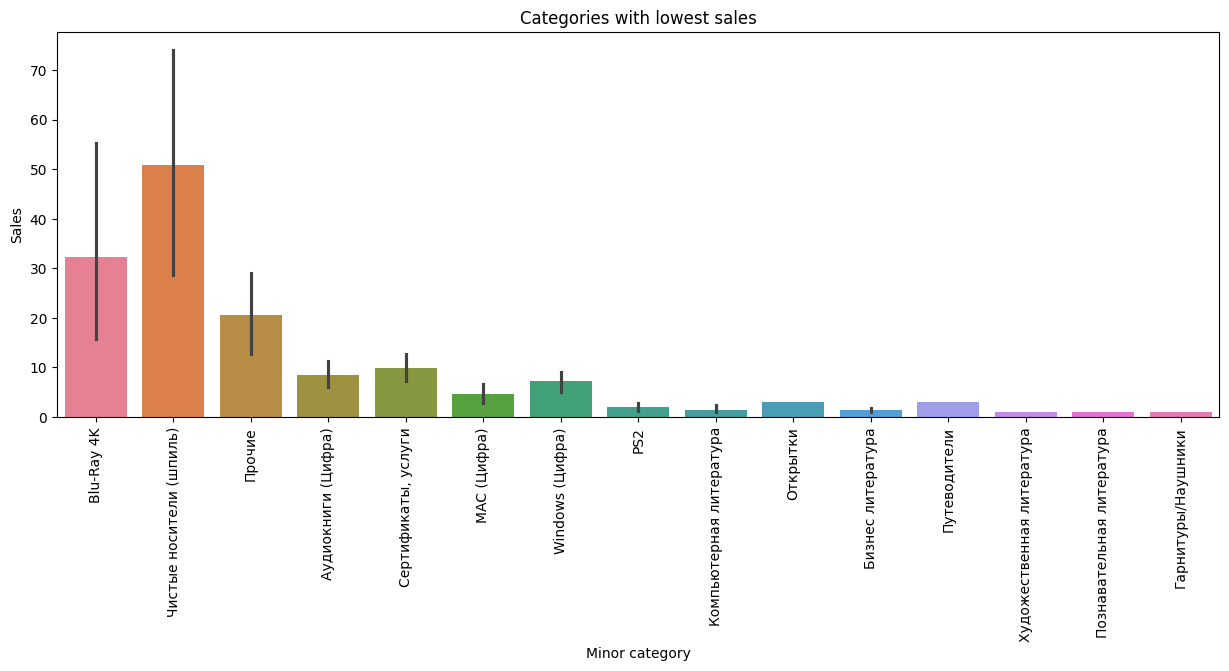

In [254]:
plt.figure(figsize = (15,5))

sns.barplot(data = sales_per_minor_category[sales_per_minor_category.minor_category.isin(bottom_categories)],
            x = 'minor_category', y = 'item_cnt_per_minor_category', hue = 'minor_category', dodge=False)

plt.title('Categories with lowest sales')
plt.xlabel('Minor category')
plt.ylabel('Sales')

plt.xticks(rotation=90)
plt.show()

The slice with the lowest sales included printed products from the category 'Books'. Category 'Games' is very popular among customers, although games sold for PS2 are less preferred

Time-dependence of different categories

Time tendencies for minor category

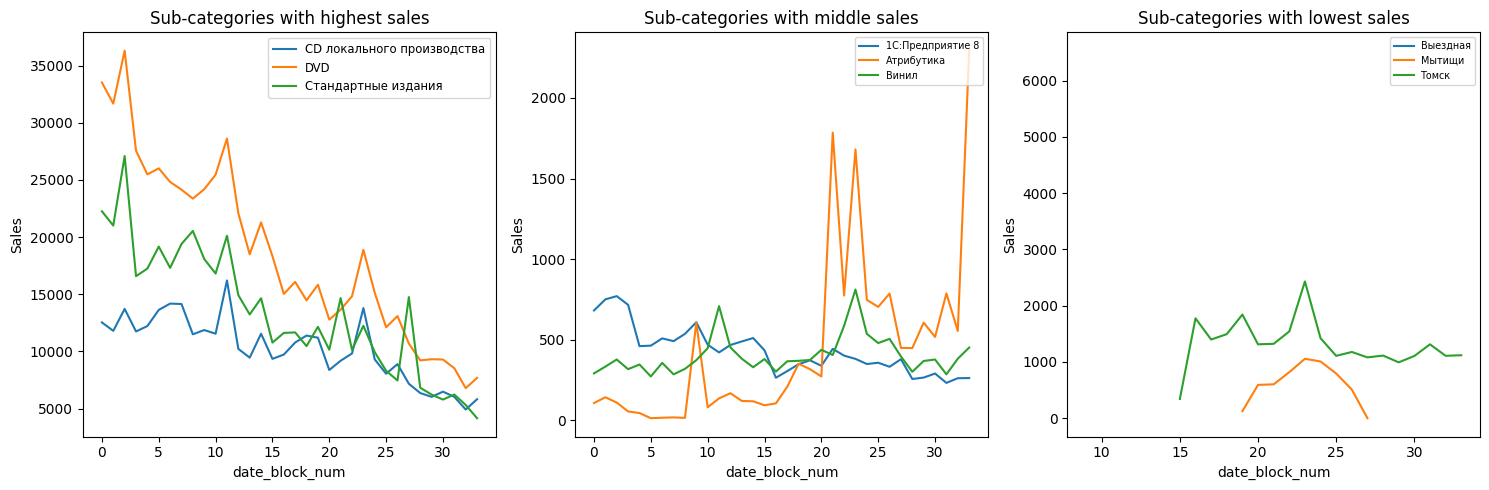

In [266]:
#Plotting sales change graphs with time period for highest, average and lowest sales for 3 category each 
top_categories = minor_category_sorted.iloc[:3].minor_category
highest = (pd.pivot_table(sales_per_minor_category[sales_per_minor_category.minor_category.isin(top_categories)],
           values='item_cnt_per_minor_category', columns=['date_block_num'], index=['minor_category'], aggfunc="sum").T)
middle_categories = minor_category_sorted.iloc[(len(minor_category_sorted)//2-1):(len(minor_category_sorted)//2+2)].minor_category
middle = (pd.pivot_table(sales_per_minor_category[sales_per_minor_category.minor_category.isin(middle_categories)],
           values='item_cnt_per_minor_category', columns=['date_block_num'], index=['minor_category'], aggfunc="sum").T)
bottom_categories = minor_category_sorted.iloc[-3:].minor_category
borrom = (pd.pivot_table(sales_per_minor_category[sales_per_minor_category.minor_category.isin(bottom_categories)],
           values='item_cnt_per_minor_category', columns=['date_block_num'], index=['minor_category'], aggfunc="sum").T)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))

p1 = highest.plot(ax=axes[0], ylabel = 'Sales', title = 'Sub-categories with highest sales')
p1.legend(loc = 'upper right', fontsize = 'small')
p2 = middle.plot(ax=axes[1], ylabel = 'Sales', title = 'Sub-categories with middle sales')
p2.legend(loc = 'upper right', fontsize = 'x-small')
p3 = lowest.plot(ax=axes[2], ylabel = 'Sales', title = 'Sub-categories with lowest sales')
p3.legend(loc = 'upper right', fontsize = 'x-small')

plt.tight_layout()
plt.show()


For the subcategories with the most sales, we see a general trend of decreasing sales over time. For the categories with the average number of sales, the trends are different, and missing pieces of data are starting to appear. For the subcategories with the lowest number of sales, there is almost no data.

C:\Users\User\AppData\Local\Temp\ipykernel_36548\1822092560.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', fontsize = 'x-small')


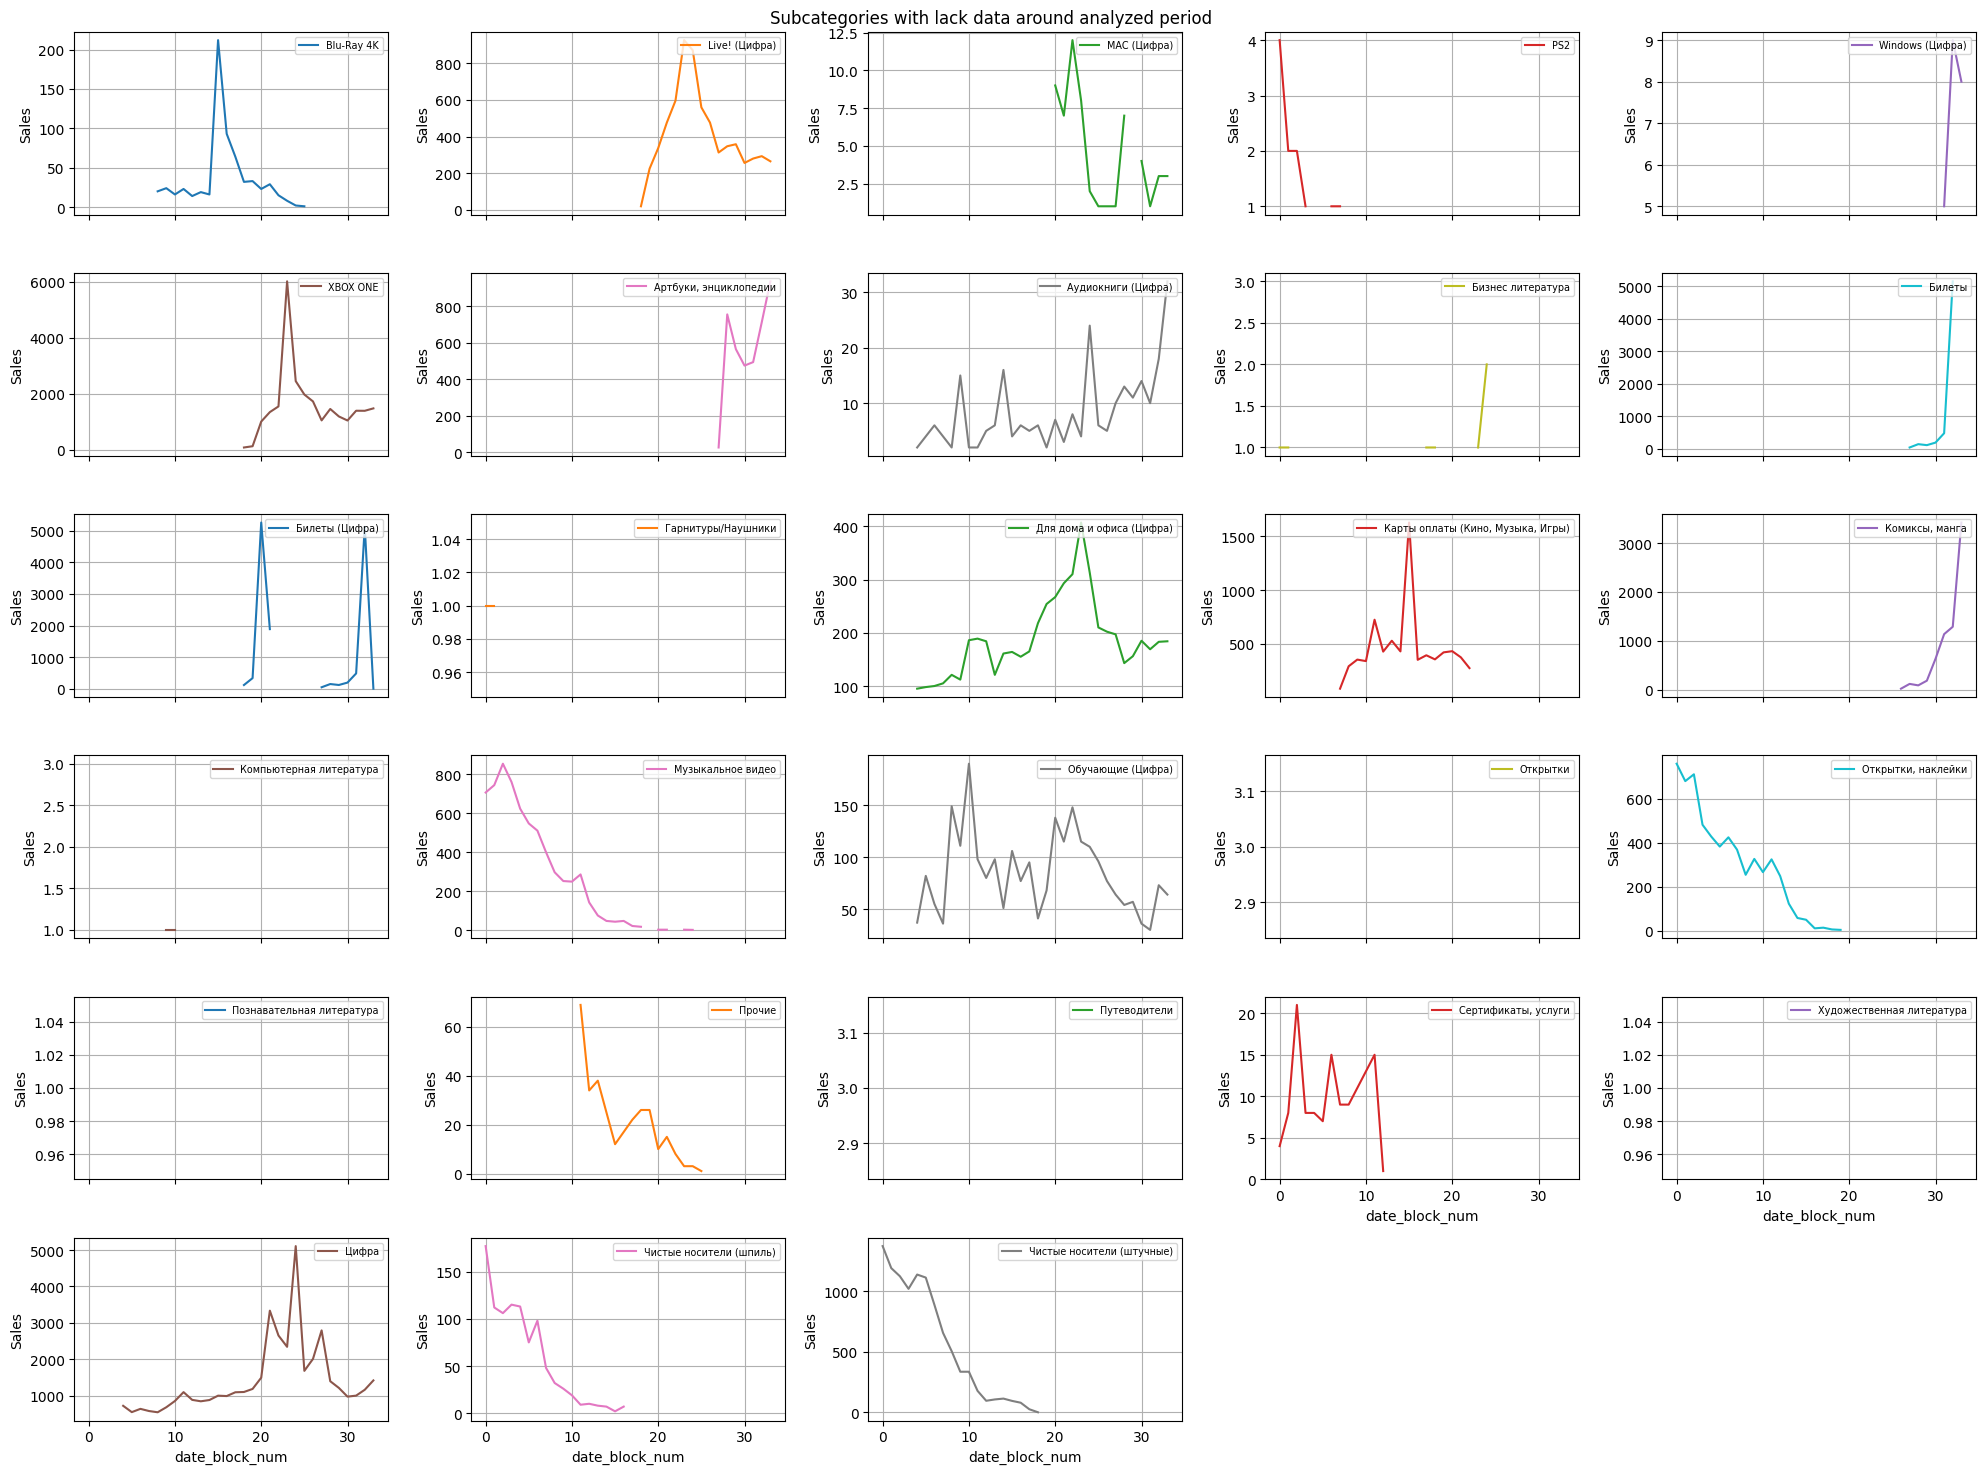

Percentage of subcategories with missings: 42%


In [261]:
#Plotting not full data subcategories
subcategories = pd.pivot_table(sales_per_minor_category, values='item_cnt_per_minor_category', columns=['date_block_num'], index=['minor_category'], aggfunc="sum")
axes = (subcategories[subcategories.isna().any(axis = 1)].T
        .plot(subplots = True, layout = (6,5), grid=True,sharex=True, sharey=False,figsize=(20,15),
        title = 'Subcategories with lack data around analyzed period'))

axes = axes.flat 

for ax in axes:
    
    ax.legend(loc='upper right', fontsize = 'x-small')
    ax.set_ylabel('Sales')

plt.tight_layout()
plt.show()

sub = len(sales_per_minor_category.minor_category.unique())
unc_sub = len(subcategories[subcategories.isna().any(axis = 1)])
perc = unc_sub / sub
print(f'Percentage of subcategories with missings: {perc:.0%}')

Almost all incomplete subcategories contain less than 50% of data around analyzed period. Moreover, the percentage of uncomplete subcategories 42%. Just like for shops, in the future it will be useful to also add a feature that reflects the number of available time blocks for a subcategory (minor history length), thereby factoring this into the prediction.

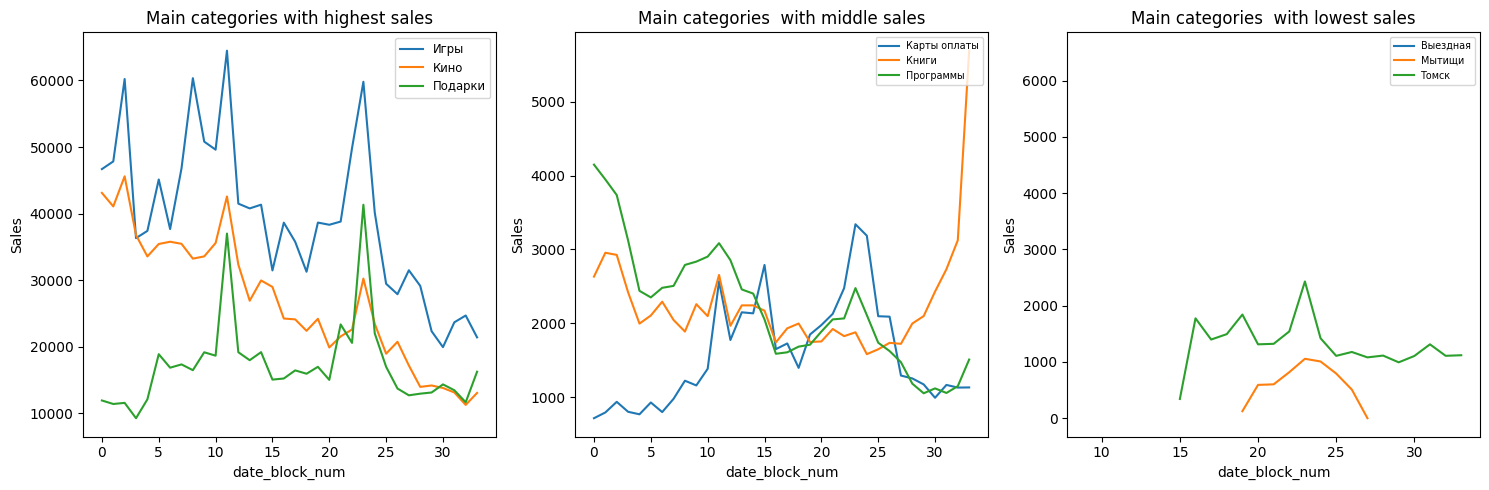

In [267]:
#Plotting sales change graphs with time period for highest, average and lowest sales for 3 category each 
main_category_sales = sales_per_main_category.groupby(['main_category'])['item_cnt_per_main_category'].sum().reset_index()
main_category_sorted = main_category_sales.sort_values(by='item_cnt_per_main_category', ascending=False)

top_categories = main_category_sorted.iloc[:3].main_category
highest = (pd.pivot_table(sales_per_main_category[sales_per_main_category.main_category.isin(top_categories)],
           values='item_cnt_per_main_category', columns=['date_block_num'], index=['main_category'], aggfunc="sum").T)
middle_categories = main_category_sorted.iloc[(len(main_category_sorted)//2-1):(len(main_category_sorted)//2+2)].main_category
middle = (pd.pivot_table(sales_per_main_category[sales_per_main_category.main_category.isin(middle_categories)],
           values='item_cnt_per_main_category', columns=['date_block_num'], index=['main_category'], aggfunc="sum").T)
bottom_categories = main_category_sorted.iloc[-3:].main_category
borrom = (pd.pivot_table(sales_per_main_category[sales_per_main_category.main_category.isin(bottom_categories)],
           values='item_cnt_per_main_category', columns=['date_block_num'], index=['main_category'], aggfunc="sum").T)


fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (15,5))

p1 = highest.plot(ax=axes[0], ylabel = 'Sales', title = 'Main categories with highest sales')
p1.legend(loc = 'upper right', fontsize = 'small')
p2 = middle.plot(ax=axes[1], ylabel = 'Sales', title = 'Main categories  with middle sales')
p2.legend(loc = 'upper right', fontsize = 'x-small')
p3 = lowest.plot(ax=axes[2], ylabel = 'Sales', title = 'Main categories  with lowest sales')
p3.legend(loc = 'upper right', fontsize = 'x-small')

plt.tight_layout()
plt.show()


Almost all categories show a decline in sales during the analyzed period. At the end of the period for the Books category, a spike in sales is visible, which may indicate an outlier. Bright seasonality is observed for the Game Consoles category towards the end of each year.

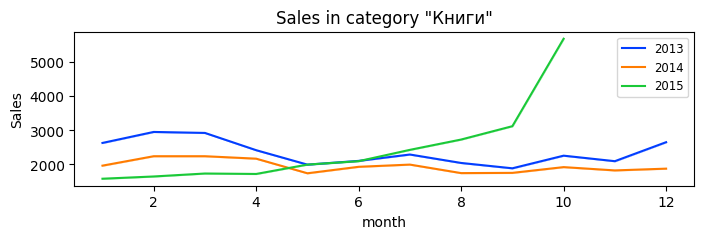

In [286]:
#Plot of category Книги
sales_per_main_category = sales_per_main_category.merge(train.loc[:, ['date_block_num', 'month', 'year']], on = 'date_block_num', how = 'left')
plt.figure(figsize = (8,2))

sns.lineplot(data = sales_per_main_category[sales_per_main_category.main_category == 'Книги'],
             x = 'month', y = 'item_cnt_per_main_category', hue = 'year', 
             palette='bright').set_title('Sales in category "Книги"')

plt.ylabel('Sales')
plt.legend(loc = 'upper right', fontsize = 'small')

plt.show()

In [343]:
train = train.merge(categories_items, on = 'item_id', how = 'left')

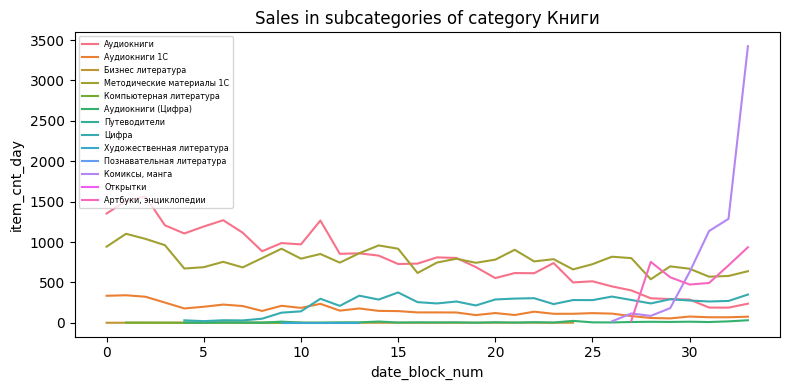

In [289]:
group = train[train.main_category == 'Книги'].groupby(['date_block_num', 'minor_category'])['item_cnt_day'].sum().reset_index()
plt.figure(figsize = (8,4))

sns.lineplot(group, x = 'date_block_num', y = 'item_cnt_day', hue = 'minor_category')

plt.legend(loc = 'upper left', fontsize = 'xx-small')
plt.title('Sales in subcategories of category Книги')

plt.tight_layout()
plt.show()

In [ ]:
#Check if we have this items in test set
manga_id = list(train[train.minor_category == 'Комиксы, манга'].item_id.unique())
print(f'Amount of items from subcategory Комиксы, манга :{len(test[test.item_id.isin(manga_id)])}')
art_id = list(train[train.minor_category == 'Артбуки, энциклопедии'].item_id.unique())
print(f'Amount of items from subcategory Артбуки, энциклопедии :{len(test[test.item_id.isin(art_id)])}')

Amount of items from subcategory Комиксы, манга :5334
Amount of items from subcategory Артбуки, энциклопедии :378


We see a jump in sales for the Comics and Manga and Artbooks subcategories. Sales data for this product is available for the last 8 months. It would be dangerous to remove the data, as we would need to make predictions for items from this categories.

main categories and item_cnt_month

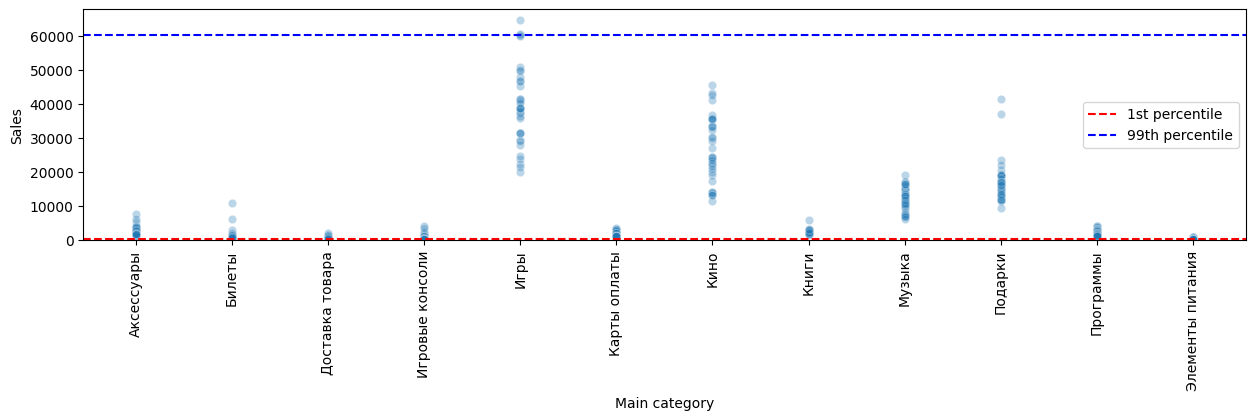

In [297]:
group = (train.groupby(['date_block_num', 'main_category'])['item_cnt_day'].
        sum().rename('item_cnt_per_main_category').reset_index())
q1 = group['item_cnt_per_main_category'].quantile(0.05)
q99 = group['item_cnt_per_main_category'].quantile(0.995)

plt.figure(figsize = (15,3))
sns.scatterplot(data = group, x = group.main_category, y = group.item_cnt_per_main_category, alpha=0.3)

plt.axhline(q1, color='red', linestyle='--', label='1st percentile')
plt.axhline(q99, color='blue', linestyle='--', label='99th percentile')

plt.xlabel('Main category')
plt.ylabel('Sales')
plt.ylim(bottom = -200)

plt.legend()
plt.xticks(rotation=90)
plt.show()

Games

In [315]:
group[(group.main_category == 'Игры') & (group.item_cnt_per_main_category > 60000)]

,date_block_num,main_category,item_cnt_per_main_category
28,2,Игры,60218.0
100,8,Игры,60339.0
136,11,Игры,64470.0


The biggest category in our set - Games: we need to make a lot of predictions. To get stable results on date_block 34 it will be reasoble not to take into account first year(12 months)

Main categories and item price

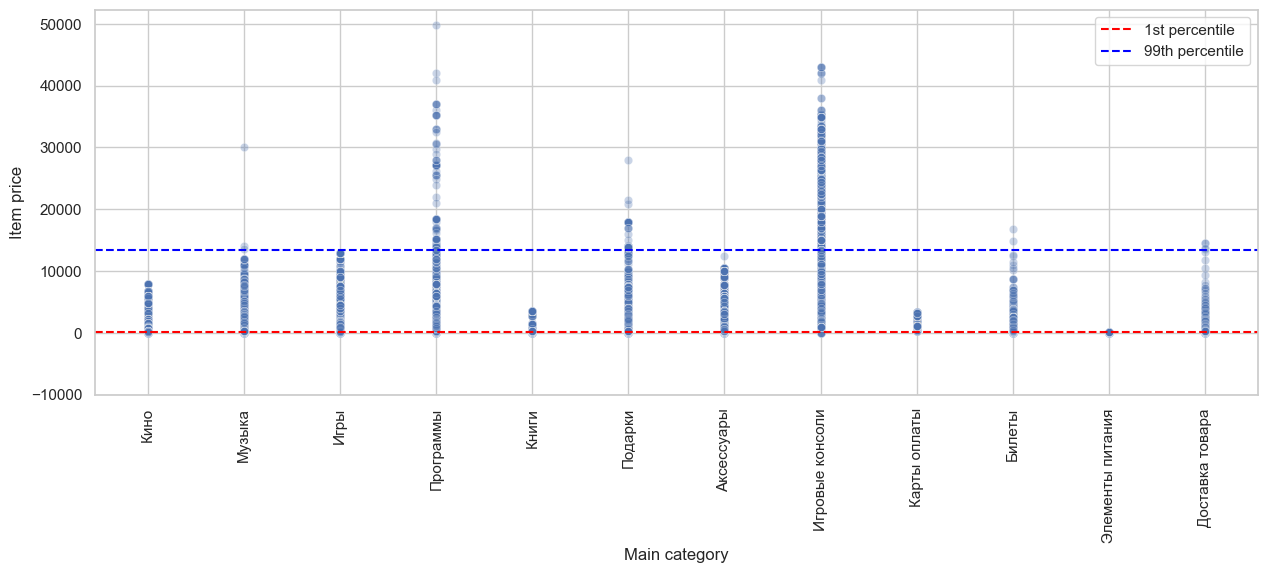

In [316]:
q1 = train['item_price'].quantile(0.05)
q99 = train['item_price'].quantile(0.995)

plt.figure(figsize = (15,5))
sns.scatterplot(data = train, x = train.main_category, y = train.item_price, alpha=0.3)

plt.axhline(q1, color='red', linestyle='--', label='1st percentile')
plt.axhline(q99, color='blue', linestyle='--', label='99th percentile')

plt.xlabel('Main category')
plt.ylabel('Item price')

plt.legend()
plt.xticks(rotation=90)

plt.ylim(bottom = -10000)
plt.show()

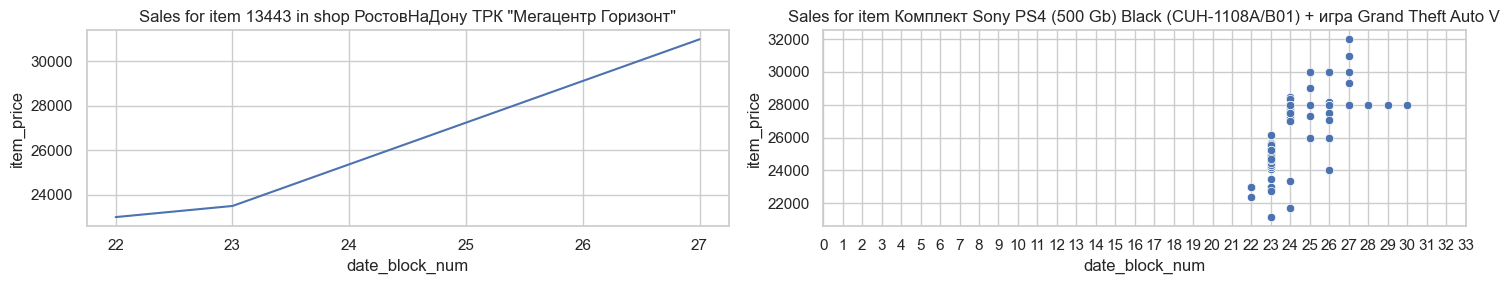

In [538]:
consols_outlier = df_train[(df_train.main_category == 'Игровые консоли') & (df_train.item_price > 30000)]
shop_id_out = consols_outlier.shop_id.values[0]
item_id_out = consols_outlier.item_id.values[0]
fig,axes = plt.subplots(1,2, figsize = (15,3))
sns.lineplot(data = df_train[(df_train.shop_id == shop_id_out) & (df_train.item_id == item_id_out)], x = 'date_block_num', y = 'item_price', ax = axes[0])
axes[0].set_title(f'Sales for item {item_id_out} in shop {df_shops[df_shops.shop_id == shop_id_out].iloc[0]['shop_name']}')
sns.scatterplot(data = df_train[df_train.item_id == item_id_out], x = 'date_block_num', y = 'item_price', ax = axes[1])

plt.xticks(ticks=range(0,34))
plt.title(f'Sales for item {df_items[df_items.item_id == item_id_out].iloc[0]['item_name']}')

plt.tight_layout()
plt.show()

The price increase is probably due to the approaching game release date

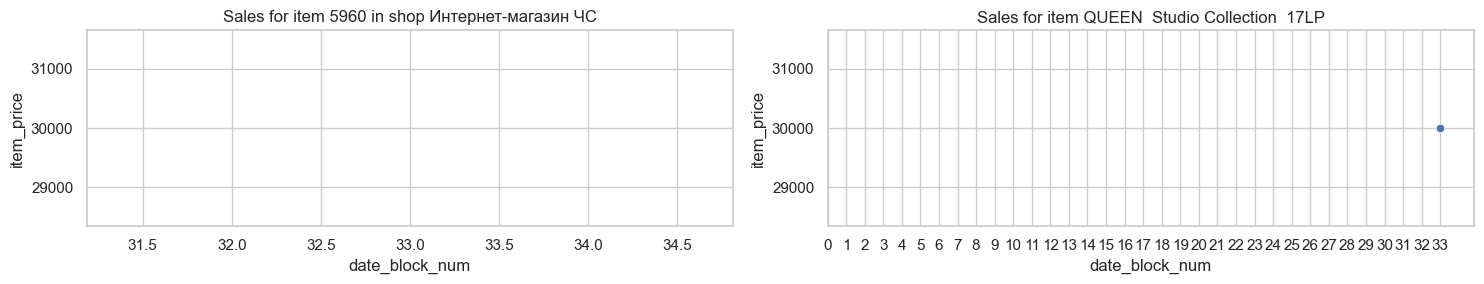

In [317]:
music_outlier = train[(train.main_category == 'Музыка') & (train.item_price > 20000)]
shop_id_out = music_outlier.shop_id.values[0]
item_id_out = music_outlier.item_id.values[0]
fig,axes = plt.subplots(1,2, figsize = (15,3))
sns.lineplot(data = train[(train.shop_id == shop_id_out) & (train.item_id == item_id_out)], x = 'date_block_num', y = 'item_price', ax = axes[0])
axes[0].set_title(f'Sales for item {item_id_out} in shop {shops[shops.shop_id == shop_id_out].iloc[0]['shop_name']}')
sns.scatterplot(data = train[train.item_id == item_id_out], x = 'date_block_num', y = 'item_price', ax = axes[1])

plt.xticks(ticks=range(0,34))
plt.title(f'Sales for item {items[items.item_id == item_id_out].iloc[0]['item_name']}')

plt.tight_layout()
plt.show()

In [319]:
test[test.item_id == 5960]

,Unnamed: 0,ID,shop_id,item_id


We do not have it in test set, also it contains data only for one sale. It will be reasonable to drop it.

In [320]:
train.drop(train[(train.item_id == 5960)].index, inplace = True)

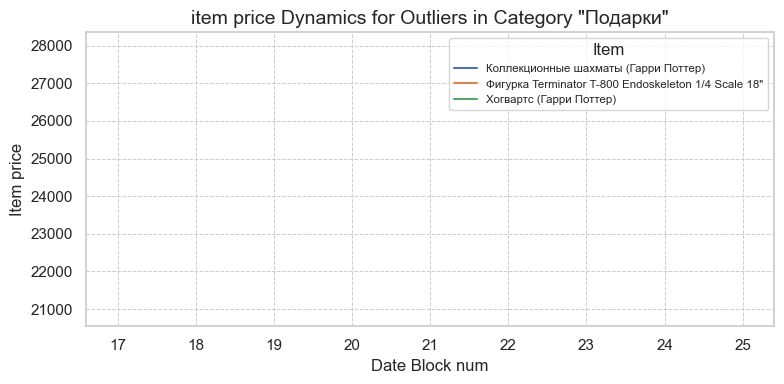

In [321]:
sns.set(style="whitegrid")

gifts_outliers = train[(train.main_category == 'Подарки') & (train.item_price > 20000)]
gifts_outliers = pd.merge(gifts_outliers, items, on = 'item_id', how = 'left')
gifts_item_id = list(gifts_outliers.item_id.unique())

pivot_data = pd.pivot_table(train[train.item_id.isin(gifts_item_id)], 
                            index='item_name', 
                            columns='date_block_num', 
                            values='item_price', 
                            aggfunc="sum").T


plt.figure(figsize=(8,4))
pivot_data.plot(ax=plt.gca())

plt.xlabel('Date Block num', fontsize=12)
plt.ylabel('Item price', fontsize=12)
plt.title('item price Dynamics for Outliers in Category "Подарки"', fontsize=14)


plt.grid(True, which='both', linestyle='--', linewidth=0.7)

#plt.ylim(0, 15000)

plt.legend(title='Item', loc='upper right', fontsize = 'x-small')

plt.tight_layout()
plt.show()

In [323]:
train[train.item_id.isin(gifts_item_id)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,item_category_name,item_category_id,main_category,main_category_id,minor_category,minor_category_id,item_name
1708161,02.06.2014,17,25,20842,20899.0,1.0,6,2014,Подарки - Фигурки,72,Подарки,9,Фигурки,61,Фигурка Terminator T-800 Endoskeleton 1/4 Scal...
2143961,26.11.2014,22,12,21483,21499.0,1.0,11,2014,Подарки - Сувениры,69,Подарки,9,Сувениры,58,Хогвартс (Гарри Поттер)
2462846,26.02.2015,25,12,13200,28000.0,1.0,2,2015,Подарки - Сувениры,69,Подарки,9,Сувениры,58,Коллекционные шахматы (Гарри Поттер)


In [327]:
test[test.item_id.isin(gifts_item_id)]

,ID,shop_id,item_id


We do not have it in test set, also it contains data only for one sale. It will be reasonable to drop it.

In [328]:
train.drop(train[(train.item_id.isin(gifts_item_id))].index, inplace = True)

C:\Users\User\AppData\Local\Temp\ipykernel_36548\2213307301.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


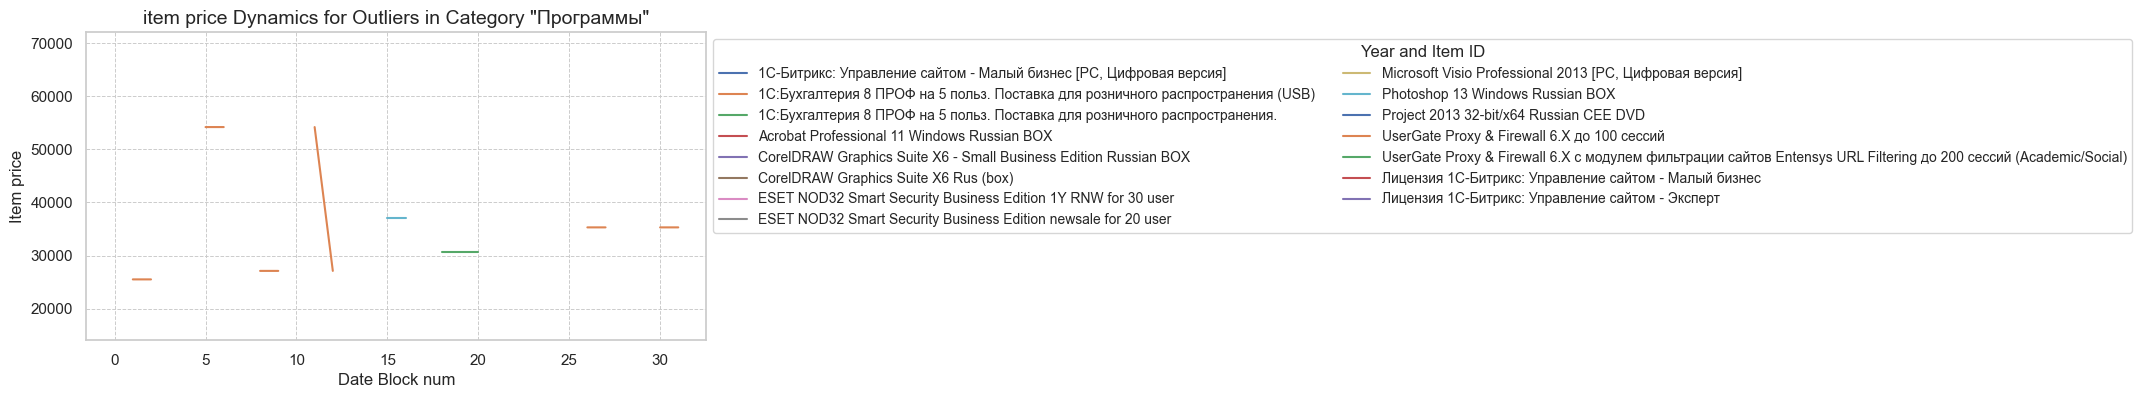

In [330]:
sns.set(style="whitegrid")

programmes_outliers = train[(train.main_category == 'Программы') & (train.item_price > 20000)]
programmes_outliers = pd.merge(programmes_outliers, items, on = 'item_id', how = 'left')
programmes_item_id = list(programmes_outliers.item_id.unique())

pivot_data = pd.pivot_table(train[train.item_id.isin(programmes_item_id)], 
                            index='item_name', 
                            columns='date_block_num', 
                            values='item_price', 
                            aggfunc="sum").T


plt.figure(figsize=(8,4))
pivot_data.plot(ax=plt.gca())

plt.xlabel('Date Block num', fontsize=12)
plt.ylabel('Item price', fontsize=12)
plt.title('item price Dynamics for Outliers in Category "Программы"', fontsize=14)


plt.grid(True, which='both', linestyle='--', linewidth=0.7)

plt.legend(title='Year and Item ID', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10, ncol=2)

plt.tight_layout()
plt.show()

In [331]:
test[test.item_id.isin(programmes_item_id)]

,ID,shop_id,item_id


The data for this category with the product price boundary over 20,000 is fragmentary - it will be difficult to make any predictions based on it. The data also includes quite extreme values ​​for item_price. Our prediction set does not include them. Let's delete them.

In [332]:
train.drop(train[(train.item_id.isin(programmes_item_id))].index, inplace = True)

In [ ]:
train.drop(['month', 'year', 'item_category_name', 'item_category_id',
       'main_category', 'main_category_id', 'minor_category',
       'minor_category_id', 'item_name'], axis = 1, inplace = True)

In [ ]:
to_csv(train, 'train.csv')
to_csv(categories, 'item_categories.csv')
to_csv(shops, 'shops.csv')

$Conclusions$
<br>
$1$: Number of sales is influenced by a lot of factors: item price, year, month, category and subcategory of item, shop, city.
<br>
$2$: Time (date period, year, month): Most of the sales are time-dependent. In general, we see decrease during all analyzed period of time (we also see this on time-trend during the several years) with presence of seasonality. During the year we see the increase in sales towards the end of the year, that can be associated with holiday’s period. For most of the items we see slight decrease in sales in the middle of the year. According to our data, sales have been declining with each subsequent year. For many features we do not have data for full date range - So it will be reasonable to create features that will collect feature "history"
<br>
$3$: Item price: There is no linear correlation between item_cnt_month and item price. To get more connection with sales per month, will be reasonable to create new feature – revenue(price*sales).
<br>
$4$: Category&subcategory: The highest number of sales is in categories such as Games, Movies and Gifts. The lowest sales in the categories of batteries, which may be due to product specificity. The change in sales over the analyzed period for most categories follows a common pattern. However, for the category of books there is a big jump in sales by the end of the period, which is due to the growth of sales in the subcategory of comics, manga. 42% of the subcategories lack data for the full period analyzed. Correlation between target and minor category is a little bit higher, than with main category. By grouping the data into categories, a number of anomalies were discovered in item price. 
<br>
$5$: Shop&city: Sales are vary from shop to shop and it can be due to the size of the shop. Also more sales we see in big cities, and the vast amount of sales we see in the capital – Moscow. Based on the overall graph, the online shop is 15th in terms of sales. However, it can be seen that closer to the end of the analyzed period, unlike offline shops, there is a tendency to increase sales. We have small values for the correlation between item_cnt_month and the City, but this feature provides additional information about shops, for many of which we have insufficient data.
<br>